In [1]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f442f387a0f792bb495513eadecaf4662f6b0895c2e88b8f74226dbd5b71bdab
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-03-27 05:44:10--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-03-27 05:44:11--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  

In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [4]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [5]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [6]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [7]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

        self.attention_biases = None
        self.attention_bias_idxs = None

    def compute_attention_bias(self, resolution):

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)

        attention_offsets = {}
        idxs = []

        # if N = 196, then resolution = 14
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])

        num_offsets = len(attention_offsets)

        # 각 attention head에 대해 num_offsets 만큼의 학습 가능한 Bias를 생성
        self.attention_biases = nn.Parameter(torch.zeros(self.num_heads, num_offsets).to(next(self.parameters()).device))
        self.attention_bias_idxs = torch.LongTensor(idxs).view(N, N).to(next(self.parameters()).device)

    def forward(self, x):
        B, N, C = x.shape
        resolution = int(N ** 0.5)

        if self.attention_biases is None or self.attention_bias_idxs.shape[0] != N:
            self.compute_attention_bias(resolution)

        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # q, k, v: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: (B, num_heads, N, N)
        attn_bias = self.attention_biases[:, self.attention_bias_idxs].unsqueeze(0) # attn_bias: (1, num_heads, N, N)
        attn = attn + attn_bias
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [8]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [9]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x


In [10]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [11]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [12]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [14]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=4, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=4, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [15]:
model = LevitDistilled(num_classes=9)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [16]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [17]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [18]:
class BSDALayer(nn.Module):
    def __init__(self, feature_dim, bsda_lambda=0.8) -> None:
        super().__init__()

        self.feature_dim = feature_dim
        self.bsda_lambda = bsda_lambda

        self.logvar = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
        )

        self.d = nn.Dropout(p=self.bsda_lambda)
        self.encoder = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
            nn.BatchNorm1d(self.feature_dim),
            nn.GELU(),

            nn.Linear(self.feature_dim, self.feature_dim),
            nn.BatchNorm1d(self.feature_dim),
            nn.GELU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
            nn.BatchNorm1d(self.feature_dim),
            nn.GELU(),

            nn.Linear(self.feature_dim, self.feature_dim),
            nn.BatchNorm1d(self.feature_dim),
            nn.GELU(),
        )

    def modified_indicator_function(self, x):
        return torch.where(x >= 0, torch.sign(x), -torch.sign(x))

    def calc_a_tilde(self, a, m, multi=1):
        a = a.repeat(multi, 1)
        return a + self.d(m) * self.modified_indicator_function(a)

    def reparameterize(self, mu, logvar, multi=1):
        std = torch.exp(0.5 * logvar)
        std = std.repeat(multi, 1)
        eps = torch.randn_like(std, device=std.device)
        mu = mu.repeat(multi, 1)
        return eps * std + mu

    def forward(self, a, multi=1):
        """
            a: (batch_size, feature_dim)
            m: (batch_size, feature_dim)
            mu: (batch_size, feature_dim)
            logvar: (batch_size, feature_dim)
        """
        x = self.encoder(a)

        logvar = self.logvar(x)
        mu = torch.zeros_like(logvar, device=logvar.device)

        m = self.reparameterize(mu, logvar, multi)
        a_hat = self.decoder(m)

        return m, mu, logvar, a_hat

    def calc_kl_loss(self, mu, logvar):

        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return kl_loss

    def calc_recon_loss(self, a, a_hat, multi=1):
        recon_loss = torch.mean((a.repeat(multi, 1) - a_hat) ** 2) * 0.5
        return recon_loss


In [19]:
class BSDAWarp(nn.Module):
    def __init__(self, backbone, num_classes, info, feature_dim=None, fc_name=None, bsda_kl_weight=8e-4, bsda_recon_weight=1) -> None:
        super().__init__()

        self.backbone = backbone

        self.feature_dim = 512
        self.backbone.head = nn.Identity()
        self.backbone.head_dist = nn.Identity()


        self.multi = info['bsda_multi']
        self.use_ori = info['bsda_use_ori']
        self.bsda_lambda = info['bsda_lambda']
        self.n_channels = info['n_channels']
        # self.train_eval = info['train_evaluator']
        # self.val_eval = info['val_evaluator']
        # self.test_eval = info['test_evaluator']


        self.linear = nn.Linear(self.feature_dim, num_classes)
        self.bsda_layer = BSDALayer(self.feature_dim, self.bsda_lambda)


        self.linear = self.linear.to(next(self.backbone.parameters()).device)
        self.bsda_layer = self.bsda_layer.to(next(self.backbone.parameters()).device)


        self.bsda_kl_weight = bsda_kl_weight
        self.bsda_recon_weight = bsda_recon_weight


    def get_loss(self, outputs, targets, criterion, logger=None, writer=None, epoch=None, is_train=False, bsda_alpha=0.5, task=''):
        if task == 'multi-label, binary-class':
            targets = targets.float()
        else:
            targets = targets.squeeze().long()
        if not is_train:
            # print(outputs.shape)
            # print(targets.shape)
            return criterion(outputs, targets)

        (y_hat, y_hat_tilde), (a, a_tilde, a_hat, m, mu, logvar)= outputs

        loss_task = criterion(y_hat, targets)

        if task == 'multi-label, binary-class':
            loss_task_tilde = criterion(y_hat_tilde, targets.repeat(self.multi, 1))
        else:
            loss_task_tilde = criterion(y_hat_tilde, targets.repeat(self.multi, ))

        loss_bsda_kl = self.bsda_layer.calc_kl_loss(mu, logvar)
        loss_bsda_recon = self.bsda_layer.calc_recon_loss(a, a_hat, self.multi)

        loss_bsda = loss_bsda_kl * self.bsda_kl_weight + loss_bsda_recon * self.bsda_recon_weight

        loss = loss_task_tilde + loss_bsda

        if self.use_ori:
            loss = loss * bsda_alpha + loss_task


        if logger is not None and writer is not None and epoch is not None:
            if epoch % 10 == 0:
                logger.info(f'loss: {loss.item():.4f}, loss_task: {loss_task.item():.4f}, loss_task_tilde: {loss_task_tilde.item():.4f}, loss_bsda: {loss_bsda.item():.4f}, loss_bsda_kl: {loss_bsda_kl.item():.4f}, loss_bsda_recon: {loss_bsda_recon.item():.4f}, bsda_alpha:{bsda_alpha}')
            writer.add_scalar('loss_task', loss_task.item(), epoch)
            writer.add_scalar('loss_task_tilde', loss_task_tilde.item(), epoch)
            writer.add_scalar('loss_bsda_kl', loss_bsda_kl.item(), epoch)
            writer.add_scalar('loss_bsda_recon', loss_bsda_recon.item(), epoch)
            writer.add_scalar('loss_bsda', loss_bsda.item(), epoch)
            writer.add_scalar('loss', loss.item(), epoch)
            writer.add_scalar('bsda_alpha', bsda_alpha, epoch)

        return loss

    def forward(self, x, is_train=False):
        """
            all signature accrording to the bsda paper on arxiv

            x: (batch_size, n_channels, height, width)
            a: (batch_size, feature_dim)
            y_hat: (batch_size, num_classes)
            y_hat_tilde: (batch_size, num_classes)
            a_tilde: (batch_size, feature_dim)
            a_hat: (batch_size, feature_dim)
            m: (batch_size, feature_dim)
            mu: (batch_size, feature_dim)
            logvar: (batch_size, feature_dim)
        """
        a = self.backbone(x)
        y_hat = self.linear(a)

        if not is_train:
            return y_hat

        m, mu, logvar, a_hat = self.bsda_layer(a, multi=self.multi)

        a_tilde = self.bsda_layer.calc_a_tilde(a, m, multi=self.multi)
        y_hat_tilde = self.linear(a_tilde)

        return (y_hat, y_hat_tilde), (a, a_tilde, a_hat, m, mu, logvar)


In [20]:
import argparse


parser = argparse.ArgumentParser(description='Your script description')


parser.add_argument('--resize', action='store_true', help='Resize images')
parser.add_argument('--bsda', action='store_true', help='Use BSDA')
parser.add_argument('--bsda_lambda', type=float, default=0.8, help='BSDA lambda value')
parser.add_argument('--bsda_multi', type=int, default=10, help='BSDA multi value')
parser.add_argument('--bsda_use_ori', action='store_true', help='Use original images in BSDA')
parser.add_argument('--bsda_alpha', type=float, default=0.5, help='BSDA alpha value')
parser.add_argument('--model_name', type=str, default='resnet18', help='Model name')
args_list = "--resize --bsda --bsda_lambda 0.8 --bsda_multi 10 --bsda_use_ori --bsda_alpha 0.5 --model_name resnet18".split()

args = parser.parse_args(args_list)


data_info = {
        'n_channels': 1,
        'bsda_lambda': args.bsda_lambda,
        'bsda_multi': args.bsda_multi,
        'bsda_use_ori': args.bsda_use_ori,
}
model = model
bsda_warp = BSDAWarp(model, num_classes=9, info=data_info)

In [21]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = False  # 연산 속도를 희생하고 일관된 연산을 수행

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [22]:
train_dir = './train/NCT-CRC-HE-100K'

In [23]:
from skimage.color import rgb2hed, hed2rgb
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

In [24]:
# Augmentation
aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.75),
    transforms.RandomVerticalFlip(p=0.75),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 0.5)),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [25]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [26]:
import json

with open("/content/default_index_dict.json", "r") as f:
    index_dict = json.load(f)
load_train_idx = index_dict["train_idx"]
load_val_idx = index_dict["val_idx"]
load_test_idx = index_dict["test_idx"]

In [27]:
#train_data = Subset(dataset, load_train_idx)
#val_data = Subset(dataset, load_val_idx)
#test_data = Subset(dataset, load_test_idx)

dataset_train = datasets.ImageFolder(root=train_dir, transform=aug_transform)
dataset_eval = datasets.ImageFolder(root=train_dir, transform=transform)

train_data = Subset(dataset_train, load_train_idx)
val_data = Subset(dataset_eval, load_val_idx)
test_data = Subset(dataset_eval, load_test_idx)

In [28]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lr=learning_rate, params=model.parameters())

In [30]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [31]:
def train(model, train_loader, criterion, optimizer, device, epoch, bsda_warp=None, num_epochs=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0


    ratio = min(0.5 * (epoch / (num_epochs // 2)), 0.5) if bsda_warp and num_epochs else 0

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        if bsda_warp:
            outputs = bsda_warp(inputs, is_train=True)
            loss = bsda_warp.get_loss(outputs, labels, criterion, bsda_alpha=ratio, is_train=True)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [32]:
# Global variable to track the best validation loss
best_val_loss = float('inf')

def evaluate(model, data_loader, criterion, device, epoch, phase="Validation", save_path="best_model.pth"):
    global best_val_loss  # Reference global best validation loss
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader, desc=f"{phase}")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Check if this is the best model so far (lowest validation loss)
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        torch.save(model.state_dict(), save_path)
        print(f"New best model saved with {phase} loss {epoch_loss:.4f} at {save_path}")

    #return epoch_loss, accuracy, balanced_acc

In [33]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [34]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device, epoch)
    evaluate(model, val_loader, criterion, device, epoch, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [05:33<00:00,  6.56it/s]


Train Loss: 2.8045, Train Accuracy: 77.44%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]


Validation Loss: 1.3640, Validation Accuracy: 86.59%
Balanced Accuracy: 0.8625
New best model saved with Validation loss 1.3640 at best_model.pth

Epoch 2/30


Training: 100%|██████████| 2188/2188 [05:33<00:00,  6.56it/s]


Train Loss: 0.9757, Train Accuracy: 88.41%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]


Validation Loss: 0.5676, Validation Accuracy: 89.87%
Balanced Accuracy: 0.8941
New best model saved with Validation loss 0.5676 at best_model.pth

Epoch 3/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.4666, Train Accuracy: 92.02%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]


Validation Loss: 0.6447, Validation Accuracy: 86.43%
Balanced Accuracy: 0.8545

Epoch 4/30


Training: 100%|██████████| 2188/2188 [05:32<00:00,  6.59it/s]


Train Loss: 0.2814, Train Accuracy: 94.17%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]


Validation Loss: 0.7389, Validation Accuracy: 80.93%
Balanced Accuracy: 0.7911

Epoch 5/30


Training: 100%|██████████| 2188/2188 [05:33<00:00,  6.57it/s]


Train Loss: 0.1901, Train Accuracy: 95.64%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]


Validation Loss: 0.7015, Validation Accuracy: 85.03%
Balanced Accuracy: 0.8368

Epoch 6/30


Training: 100%|██████████| 2188/2188 [05:32<00:00,  6.57it/s]


Train Loss: 0.1380, Train Accuracy: 96.53%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]


Validation Loss: 0.5296, Validation Accuracy: 82.86%
Balanced Accuracy: 0.8203
New best model saved with Validation loss 0.5296 at best_model.pth

Epoch 7/30


Training: 100%|██████████| 2188/2188 [05:33<00:00,  6.56it/s]


Train Loss: 0.1070, Train Accuracy: 97.17%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]


Validation Loss: 0.3567, Validation Accuracy: 89.85%
Balanced Accuracy: 0.8930
New best model saved with Validation loss 0.3567 at best_model.pth

Epoch 8/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.59it/s]


Train Loss: 0.0850, Train Accuracy: 97.67%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]


Validation Loss: 0.3642, Validation Accuracy: 91.61%
Balanced Accuracy: 0.9104

Epoch 9/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.61it/s]


Train Loss: 0.0716, Train Accuracy: 98.06%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.08it/s]


Validation Loss: 0.1433, Validation Accuracy: 95.99%
Balanced Accuracy: 0.9580
New best model saved with Validation loss 0.1433 at best_model.pth

Epoch 10/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0612, Train Accuracy: 98.28%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]


Validation Loss: 0.2219, Validation Accuracy: 93.97%
Balanced Accuracy: 0.9388

Epoch 11/30


Training: 100%|██████████| 2188/2188 [05:30<00:00,  6.61it/s]


Train Loss: 0.0501, Train Accuracy: 98.56%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]


Validation Loss: 0.2825, Validation Accuracy: 92.12%
Balanced Accuracy: 0.9174

Epoch 12/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0435, Train Accuracy: 98.73%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]


Validation Loss: 0.2831, Validation Accuracy: 91.45%
Balanced Accuracy: 0.9086

Epoch 13/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0395, Train Accuracy: 98.85%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]


Validation Loss: 0.1723, Validation Accuracy: 95.27%
Balanced Accuracy: 0.9489

Epoch 14/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0345, Train Accuracy: 98.96%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]


Validation Loss: 0.0992, Validation Accuracy: 96.75%
Balanced Accuracy: 0.9644
New best model saved with Validation loss 0.0992 at best_model.pth

Epoch 15/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.59it/s]


Train Loss: 0.0332, Train Accuracy: 99.02%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]


Validation Loss: 0.1290, Validation Accuracy: 95.81%
Balanced Accuracy: 0.9555

Epoch 16/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0278, Train Accuracy: 99.20%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]


Validation Loss: 0.3425, Validation Accuracy: 91.17%
Balanced Accuracy: 0.9013

Epoch 17/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0284, Train Accuracy: 99.14%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]


Validation Loss: 0.0373, Validation Accuracy: 98.83%
Balanced Accuracy: 0.9876
New best model saved with Validation loss 0.0373 at best_model.pth

Epoch 18/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0232, Train Accuracy: 99.31%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]


Validation Loss: 0.0402, Validation Accuracy: 98.79%
Balanced Accuracy: 0.9870

Epoch 19/30


Training: 100%|██████████| 2188/2188 [05:30<00:00,  6.62it/s]


Train Loss: 0.0227, Train Accuracy: 99.32%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]


Validation Loss: 0.7687, Validation Accuracy: 83.95%
Balanced Accuracy: 0.8220

Epoch 20/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.59it/s]


Train Loss: 0.0205, Train Accuracy: 99.41%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]


Validation Loss: 0.1653, Validation Accuracy: 95.12%
Balanced Accuracy: 0.9482

Epoch 21/30


Training: 100%|██████████| 2188/2188 [05:32<00:00,  6.59it/s]


Train Loss: 0.0194, Train Accuracy: 99.42%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]


Validation Loss: 0.0640, Validation Accuracy: 98.00%
Balanced Accuracy: 0.9794

Epoch 22/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0186, Train Accuracy: 99.43%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]


Validation Loss: 0.0546, Validation Accuracy: 98.42%
Balanced Accuracy: 0.9829

Epoch 23/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.61it/s]


Train Loss: 0.0166, Train Accuracy: 99.49%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]


Validation Loss: 0.0317, Validation Accuracy: 98.94%
Balanced Accuracy: 0.9890
New best model saved with Validation loss 0.0317 at best_model.pth

Epoch 24/30


Training: 100%|██████████| 2188/2188 [05:30<00:00,  6.61it/s]


Train Loss: 0.0154, Train Accuracy: 99.54%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.95it/s]


Validation Loss: 0.0541, Validation Accuracy: 98.41%
Balanced Accuracy: 0.9839

Epoch 25/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0159, Train Accuracy: 99.54%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]


Validation Loss: 0.0516, Validation Accuracy: 98.34%
Balanced Accuracy: 0.9827

Epoch 26/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0137, Train Accuracy: 99.59%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]


Validation Loss: 0.0415, Validation Accuracy: 98.71%
Balanced Accuracy: 0.9857

Epoch 27/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0134, Train Accuracy: 99.60%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]


Validation Loss: 0.1052, Validation Accuracy: 97.21%
Balanced Accuracy: 0.9705

Epoch 28/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.59it/s]


Train Loss: 0.0126, Train Accuracy: 99.63%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]


Validation Loss: 0.0492, Validation Accuracy: 98.51%
Balanced Accuracy: 0.9852

Epoch 29/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.60it/s]


Train Loss: 0.0130, Train Accuracy: 99.59%


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]


Validation Loss: 0.0399, Validation Accuracy: 98.81%
Balanced Accuracy: 0.9881

Epoch 30/30


Training: 100%|██████████| 2188/2188 [05:31<00:00,  6.61it/s]


Train Loss: 0.0107, Train Accuracy: 99.70%


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]

Validation Loss: 0.1516, Validation Accuracy: 95.65%
Balanced Accuracy: 0.9545


In [35]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [36]:
print("\nFinal Test Evaluation")
evaluate(model,test_loader, criterion, device, epoch, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [00:23<00:00, 20.13it/s]

Test Loss: 0.0402, Test Accuracy: 98.78%
Balanced Accuracy: 0.9874


In [37]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 10.01 ms
Standard Deviation: 0.70 ms
Maximum Time: 16.59 ms
Minimum Time: 9.43 ms


In [38]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul        24.35%       9.870ms        55.82%      22.622ms     471.289us       0.000us         0.00%       5.049ms     105.188us            48  
                                           aten::linear         0.42%     172.047us        28.12%      11.397ms     356.142us       0.000us         0.00%       3.595ms     112.344us            32  
         

In [39]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [40]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [41]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]

Test Loss: 0.0402, Test Accuracy: 98.78%
Overall - F1: 0.9878, Recall: 0.9874, Precision: 0.9883
Per-Class Metrics:
Class 0 - F1: 0.9987, Recall: 0.9987, Precision: 0.9987
Class 1 - F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Class 2 - F1: 0.9782, Recall: 0.9861, Precision: 0.9704
Class 3 - F1: 0.9991, Recall: 0.9988, Precision: 0.9994
Class 4 - F1: 0.9873, Recall: 0.9895, Precision: 0.9851
Class 5 - F1: 0.9880, Recall: 0.9926, Precision: 0.9834
Class 6 - F1: 0.9870, Recall: 0.9802, Precision: 0.9938
Class 7 - F1: 0.9666, Recall: 0.9521, Precision: 0.9816
Class 8 - F1: 0.9854, Recall: 0.9884, Precision: 0.9824


<Figure size 2000x1200 with 0 Axes>

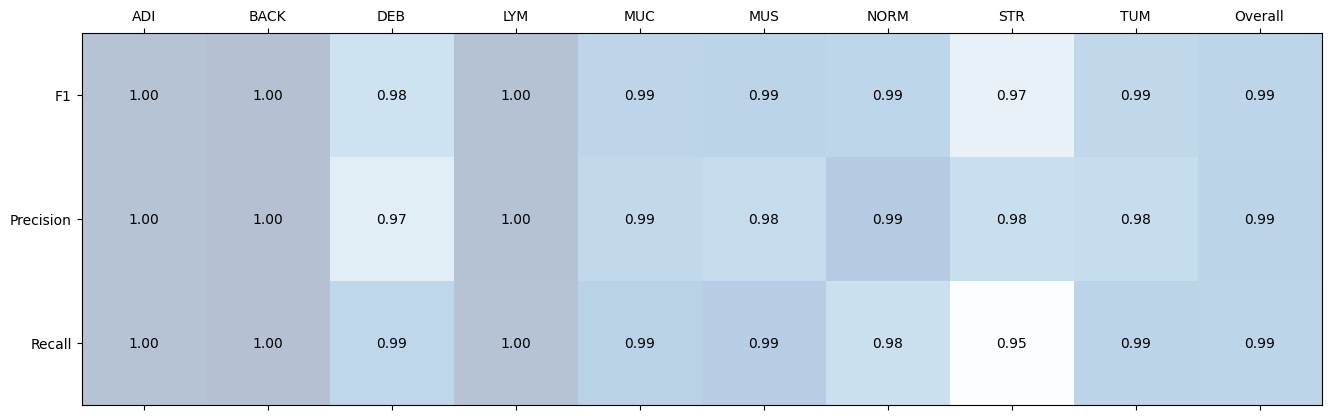

In [42]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [43]:
save_path = "HoViT_44_bsda_flip_Gaussian.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT_44_bsda_flip_Gaussian.pth
